In [1]:
import submitit
import os
import glob
import numpy as np
import pandas as pd
import mne
import submitit
import mne
import numpy as np
from tensorpac import Pac
import matplotlib.pyplot as plt
import os
import urllib
import pandas as pd
import numpy as np
from scipy.io import loadmat

from tensorpac import Pac, EventRelatedPac, PreferredPhase
from tensorpac.utils import PeakLockedTF, PSD, ITC, BinAmplitude


# prepare data 

## compute pac for each subject 

In [ ]:

def compare_ERPAC(pid, n_jobs=5):
    epoch_path = f'/mnt/data/AdaptiveControl/IBLrawdata/pid_data/{pid}/lfp_{pid}_epoched.fif'

    epochs = mne.read_epochs(epoch_path, preload=True)
    sf = epochs.info['sfreq']
    meta = epochs.metadata.reset_index()

    stim_indices = np.where(((meta['contrastLeft'] > 0.5) | (meta['contrastRight'] > 0.5)))[0]
    no_stim_indices = np.where(((meta['contrastLeft'] == 0) & (meta['contrastRight'] == 0)))[0]
    contrast_25_indices = np.where(((meta['contrastLeft'] == 0.25) | (meta['contrastRight'] == 0.25)))[0]
    contrast_12_indices = np.where(((meta['contrastLeft'] == 0.125) | (meta['contrastRight'] == 0.125)))[0]
    contrast_6_indices = np.where(((meta['contrastLeft'] == 0.0625) | (meta['contrastRight'] == 0.0625)))[0]

    afterstim_all_channel = []
    beforestim_all_channel = []
    afterstim_contrast100_list = []
    afterstim_contrast0_list = []
    afterstim_contrast25_list = []
    afterstim_contrast12_list = []
    afterstim_contrast6_list = []
    channel_names = []

    for ch in epochs.ch_names:
        epoch = epochs.copy().pick_channels([ch])

        # Extract data from epochs
        data = epoch.get_data().squeeze()  # Shape: (n_epochs, n_channels, n_times)
        data = data[:, 250:1000]
        p = EventRelatedPac(f_pha=[2, 7], f_amp=(25, 80, 5, 2))

        # extract phases and amplitudes
        pha = p.filter(sf, data, ftype='phase', n_jobs=n_jobs)
        amp = p.filter(sf, data, ftype='amplitude', n_jobs=n_jobs)
        erpac = p.fit(pha, amp, method='gc', n_jobs=n_jobs).squeeze()

        std = erpac.std(axis=(0, 1))
        mean = erpac.mean(axis=(0, 1))
        normalized_erpac = (erpac - mean) / std

        beforestim = normalized_erpac[:, 0:250].mean(axis=(0, 1))
        afterstim = normalized_erpac[:, 250:750].mean(axis=(0, 1))
        


        afterstim_all_channel.append(afterstim)
        beforestim_all_channel.append(beforestim)


        channel_names.append(ch)

    df = pd.DataFrame({
        'Channel': channel_names,
        'BeforeStim': beforestim_all_channel,
        'AfterStim': afterstim_all_channel,
    })

    # Save DataFrame to a CSV file
    save_path = f'/mnt/data/AdaptiveControl/IBLrawdata/TF_data/{pid}/PAC_stime_effect.csv'
    df.to_csv(save_path, index=False)
    
path = '/crnldata/cophy/TeamProjects/mohammad/ibl-oscillations/_analyses/_IBLworkflows/preprocessing/clean_data.csv'
df = pd.read_csv(path)

pids = df['pid'].values
for i, pid in enumerate (pids):
    
    executor = submitit.AutoExecutor(folder="logs")
    executor.update_parameters(mem_gb=20, timeout_min=600, slurm_partition="CPU", cpus_per_task=5)
    jobs = executor.submit(compare_ERPAC, pid)   




## aggregate data

In [2]:
path = '/crnldata/cophy/TeamProjects/mohammad/ibl-oscillations/_analyses/_IBLworkflows/preprocessing/clean_data.csv'
df = pd.read_csv(path)
pids = df['pid'].values


all_results = []
for pid in pids:
    
    file_path = f'/mnt/data/AdaptiveControl/IBLrawdata/TF_data/{pid}/PAC_stime_effect.csv'
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df['PID'] = pid
        all_results.append(df)


# Combine all the results into a single DataFrame
aggregated_df = pd.concat(all_results, ignore_index=True)
aggregated_df.to_csv('pac_stim_aggregated.csv', index=False)    
    





# plot the distribution of before and after average pac values + remove outliers (+- 2 zscore)

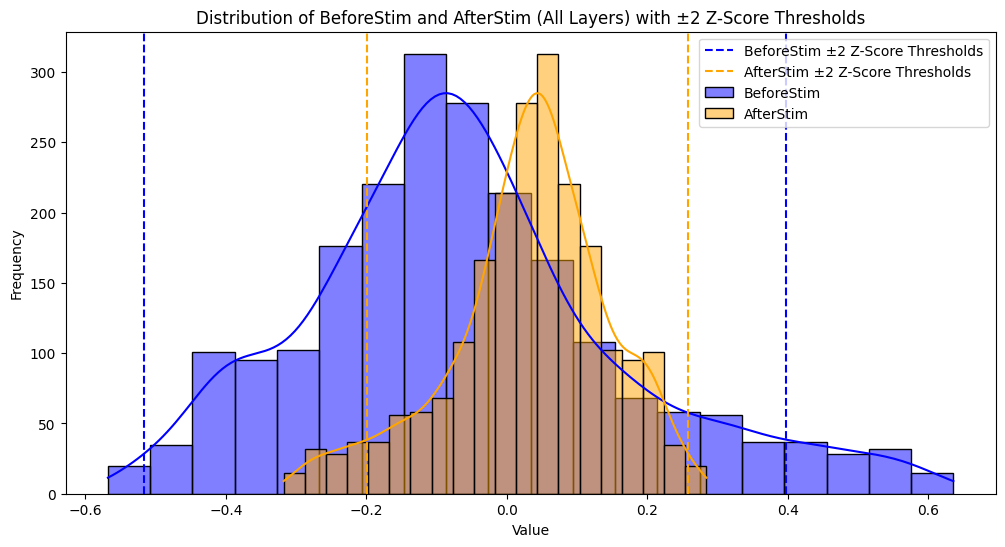

In [8]:

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

# Load the data
data = pd.read_csv('pac_stim_aggregated.csv')
data['Layer'] = data['Channel'].str.extract(r'(VISp\d)')
# Calculate z-scores for BeforeStim and AfterStim across the entire dataset
data['BeforeStim_zscore'] = zscore(data['BeforeStim'])
data['AfterStim_zscore'] = zscore(data['AfterStim'])

# Plot distribution of BeforeStim
plt.figure(figsize=(12, 6))
sns.histplot(data['BeforeStim'], kde=True, color='blue', label='BeforeStim', bins=20)

# Plot distribution of AfterStim
sns.histplot(data['AfterStim'], kde=True, color='orange', label='AfterStim', bins=20)

# Calculate mean and standard deviation for the entire dataset
before_mean = data['BeforeStim'].mean()
before_std = data['BeforeStim'].std()
after_mean = data['AfterStim'].mean()
after_std = data['AfterStim'].std()

# Plot threshold lines for BeforeStim
plt.axvline(before_mean + 2 * before_std, color='blue', linestyle='--', label='BeforeStim ±2 Z-Score Thresholds')
plt.axvline(before_mean - 2 * before_std, color='blue', linestyle='--')

# Plot threshold lines for AfterStim
plt.axvline(after_mean + 2 * after_std, color='orange', linestyle='--', label='AfterStim ±2 Z-Score Thresholds')
plt.axvline(after_mean - 2 * after_std, color='orange', linestyle='--')

# Add titles and labels
plt.title('Distribution of BeforeStim and AfterStim (All Layers) with ±2 Z-Score Thresholds')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

# Show the plot
plt.show()



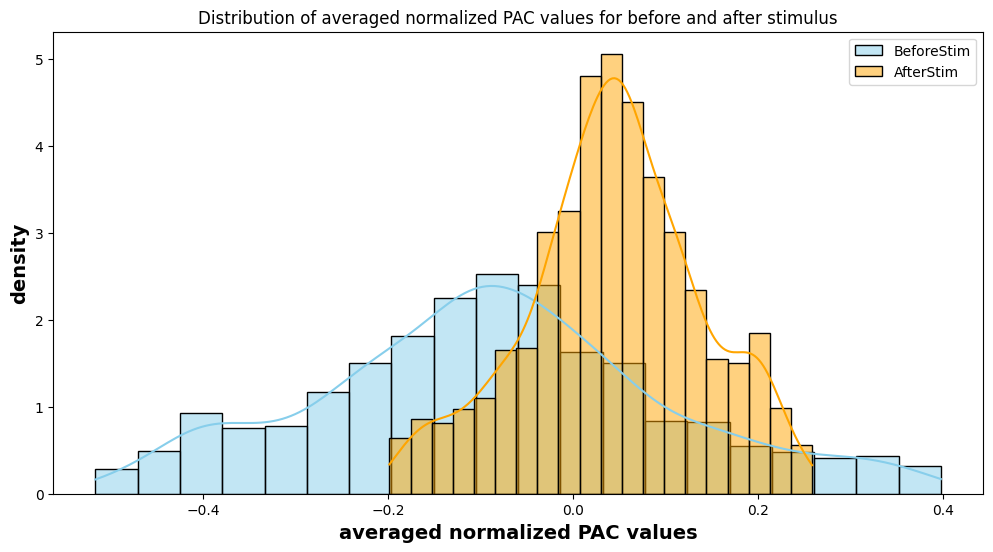

In [9]:

# Filter out rows where the absolute z-score is greater than 2
filtered_data = data[
    (data['BeforeStim_zscore'].abs() <= 2) | 
    (data['AfterStim_zscore'].abs() <= 2)
]
# Plot distribution of BeforeStim
plt.figure(figsize=(12, 6))
sns.histplot(filtered_data['BeforeStim'], kde=True, color='skyblue', label='BeforeStim', bins=20, stat='density')

# Plot distribution of AfterStim
sns.histplot(filtered_data['AfterStim'], kde=True, color='orange', label='AfterStim', bins=20, stat='density')
plt.title('Distribution of averaged normalized PAC values for before and after stimulus')
plt.xlabel('averaged normalized PAC values', fontsize=14, fontweight='bold')
plt.ylabel('density', fontsize=14, fontweight='bold')
plt.legend()

# Show the plot
plt.show()

# other ways to remove outliers : zoom out and zoom in
just in case (skip for now)

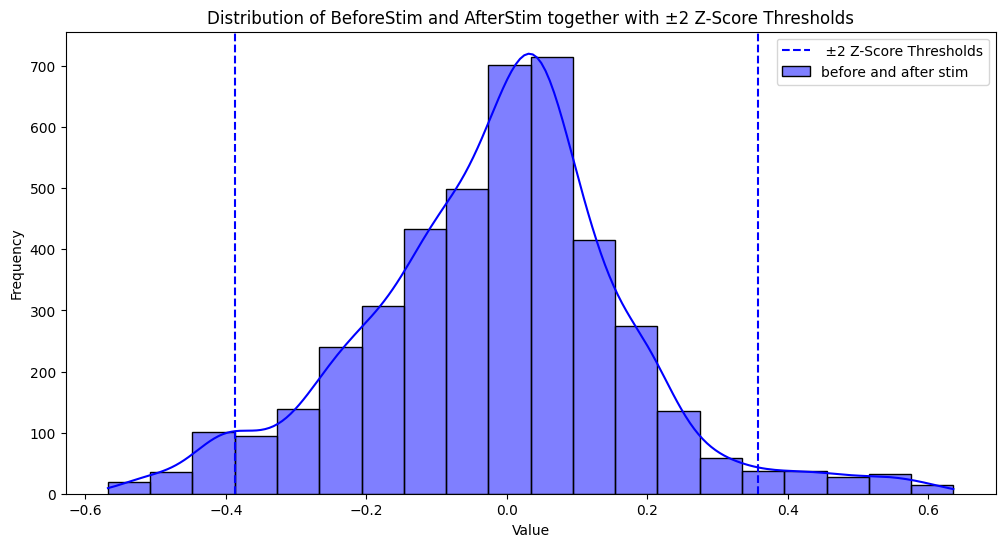

In [17]:

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

# Load the data
data = pd.read_csv('pac_stim_aggregated.csv')
data['Layer'] = data['Channel'].str.extract(r'(VISp\d)')
all_values = np.concatenate([data['BeforeStim'], data['AfterStim']])
# # Calculate z-scores for BeforeStim and AfterStim across the entire dataset
all_values_zscore = zscore(all_values)
# data['AfterStim_zscore'] = zscore(data['AfterStim'])

# # Plot distribution of BeforeStim
plt.figure(figsize=(12, 6))
sns.histplot(all_values, kde=True, color='blue', label='before and after stim ', bins=20)
all_values_mean = all_values.mean()
all_values_std = all_values.std()
plt.axvline(all_values_mean + 2 * all_values_std, color='blue', linestyle='--', label=' ±2 Z-Score Thresholds')
plt.axvline(all_values_mean - 2 * all_values_std, color='blue', linestyle='--')
# # Plot distribution of AfterStim
# sns.histplot(data['AfterStim'], kde=True, color='orange', label='AfterStim', bins=20)

# # Calculate mean and standard deviation for the entire dataset
# before_mean = data['BeforeStim'].mean()
# before_std = data['BeforeStim'].std()
# after_mean = data['AfterStim'].mean()
# after_std = data['AfterStim'].std()

# # Plot threshold lines for BeforeStim
# plt.axvline(before_mean + 2 * before_std, color='blue', linestyle='--', label='BeforeStim ±2 Z-Score Thresholds')
# plt.axvline(before_mean - 2 * before_std, color='blue', linestyle='--')

# # Plot threshold lines for AfterStim
# plt.axvline(after_mean + 2 * after_std, color='orange', linestyle='--', label='AfterStim ±2 Z-Score Thresholds')
# plt.axvline(after_mean - 2 * after_std, color='orange', linestyle='--')

# # Add titles and labels
plt.title('Distribution of BeforeStim and AfterStim together with ±2 Z-Score Thresholds')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

# Show the plot
plt.show()
# # layer_averaged_data = data.groupby(['PID', 'Layer']).agg({
# #     'BeforeStim': 'mean',
# #     'AfterStim': 'mean'
# # }).reset_index()


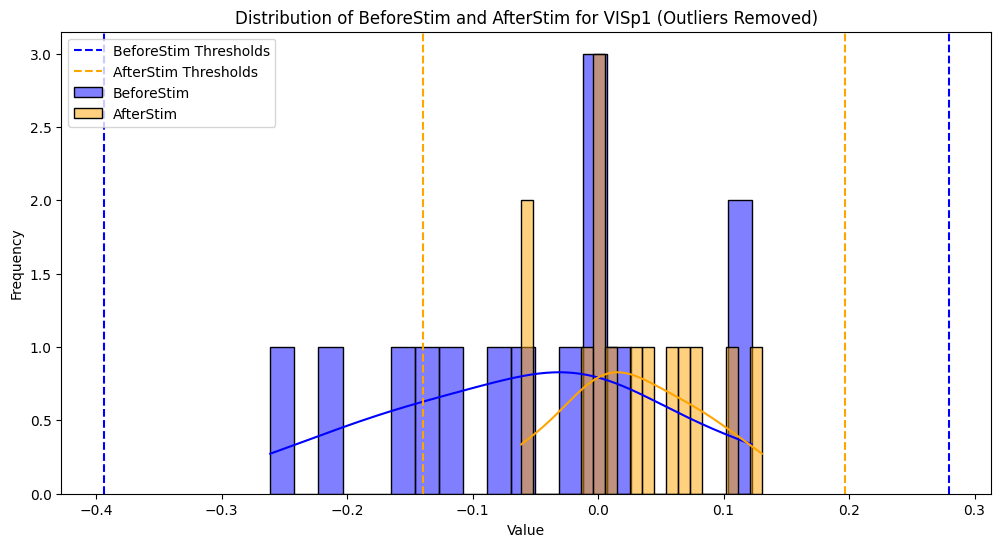

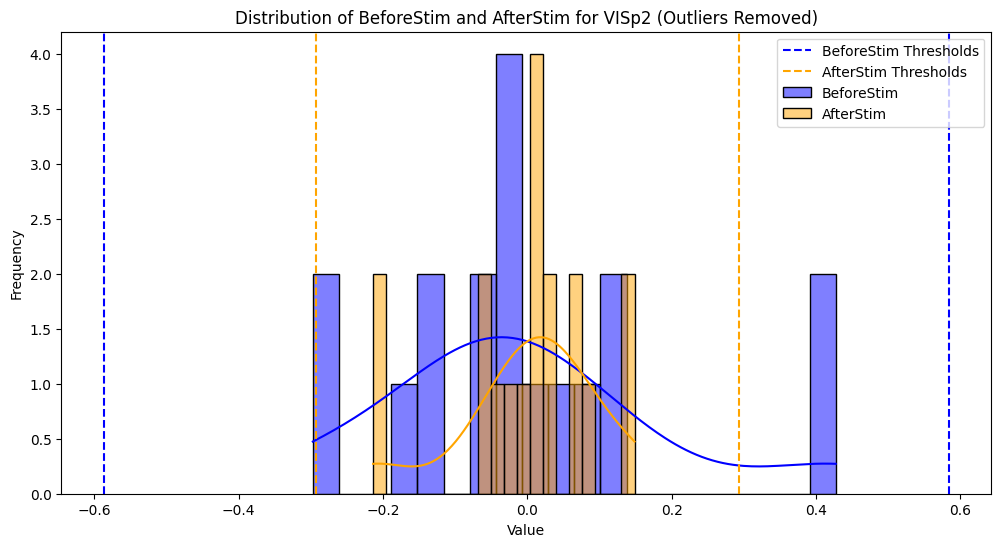

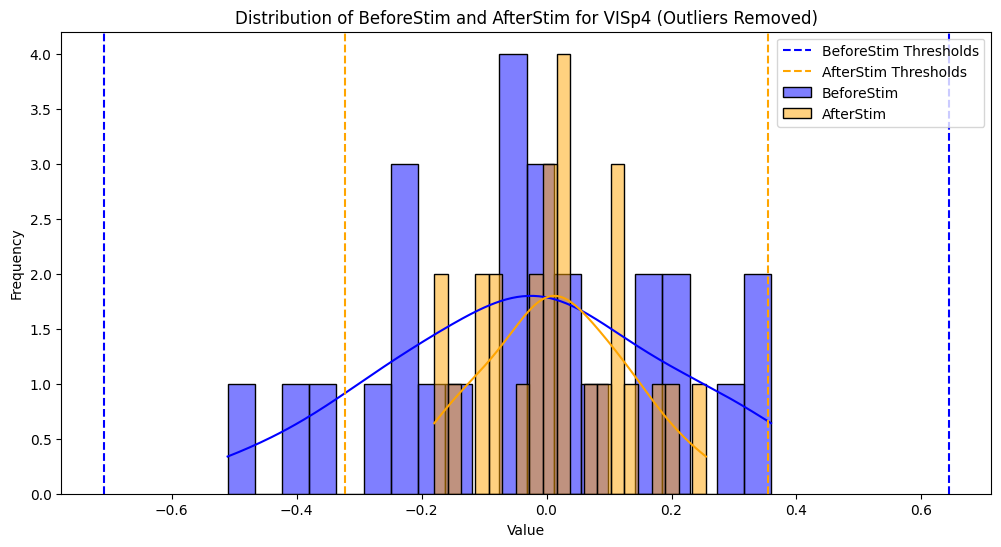

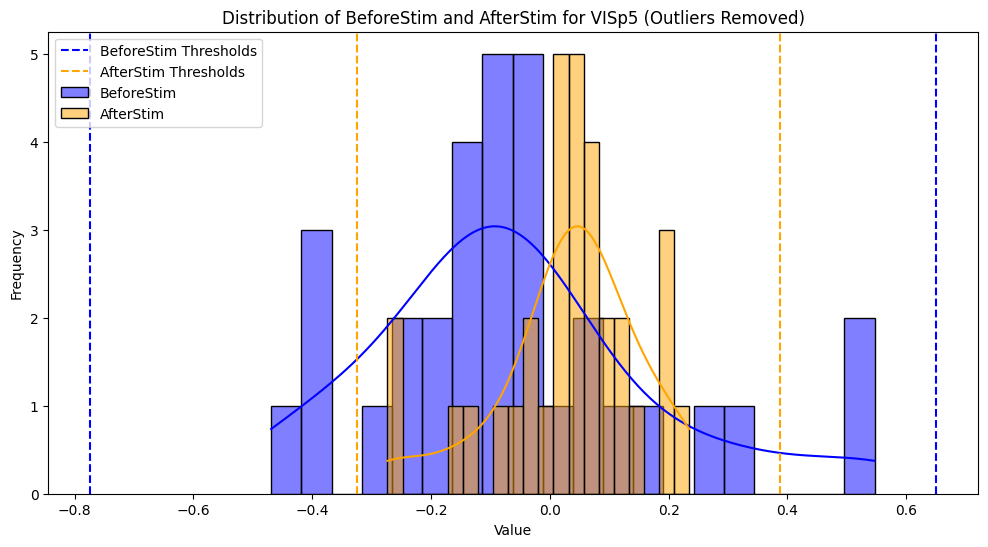

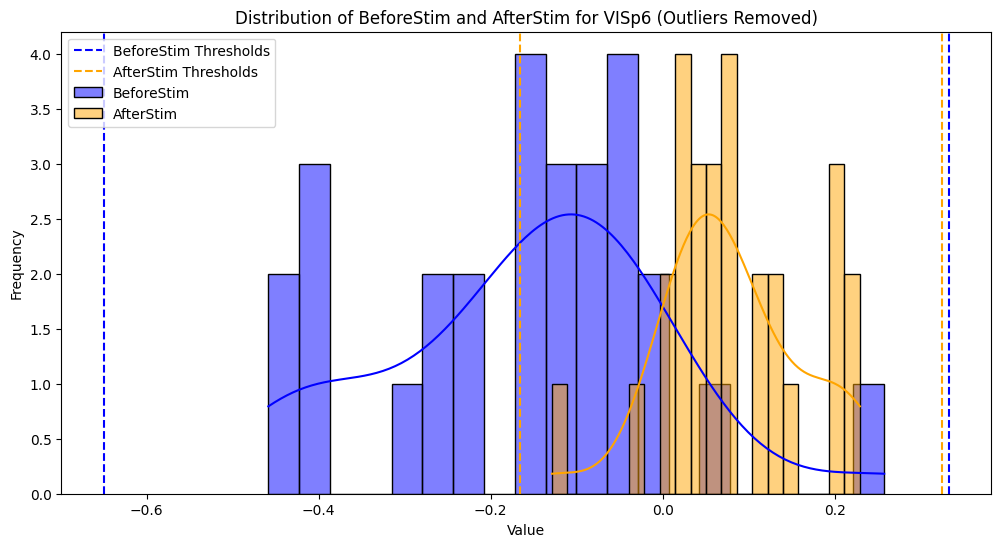

In [7]:
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate z-scores for each layer before and after stim
layer_averaged_data['BeforeStim_zscore'] = layer_averaged_data.groupby('Layer')['BeforeStim'].transform(zscore)
layer_averaged_data['AfterStim_zscore'] = layer_averaged_data.groupby('Layer')['AfterStim'].transform(zscore)

# Filter out the data points with z-scores outside the ±3 range
filtered_data = layer_averaged_data[
    (layer_averaged_data['BeforeStim_zscore'].abs() <= 3) &
    (layer_averaged_data['AfterStim_zscore'].abs() <= 3)
]

# Plotting the distribution for each layer
unique_layers = filtered_data['Layer'].unique()

for layer in unique_layers:
    plt.figure(figsize=(12, 6))
    
    # Filter data for the specific layer
    layer_data = filtered_data[filtered_data['Layer'] == layer]
    
    # Plot distribution of BeforeStim
    sns.histplot(layer_data['BeforeStim'], kde=True, color='blue', label='BeforeStim', bins=20)
    
    # Plot distribution of AfterStim
    sns.histplot(layer_data['AfterStim'], kde=True, color='orange', label='AfterStim', bins=20)
    
    # Calculate mean and standard deviation for thresholds
    before_mean = layer_data['BeforeStim'].mean()
    before_std = layer_data['BeforeStim'].std()
    after_mean = layer_data['AfterStim'].mean()
    after_std = layer_data['AfterStim'].std()
    
    # Plot threshold lines for BeforeStim
    plt.axvline(before_mean + 3 * before_std, color='blue', linestyle='--', label='BeforeStim Thresholds')
    plt.axvline(before_mean - 3 * before_std, color='blue', linestyle='--')
    
    # Plot threshold lines for AfterStim
    plt.axvline(after_mean + 3 * after_std, color='orange', linestyle='--', label='AfterStim Thresholds')
    plt.axvline(after_mean - 3 * after_std, color='orange', linestyle='--')
    
    # Add titles and labels
    plt.title(f'Distribution of BeforeStim and AfterStim for {layer} (Outliers Removed)')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()
    
    # Show the plot
    plt.show()


# average over layers and do boxplot

In [6]:
layer_averaged_data = filtered_data.groupby(['PID', 'Layer']).agg({
    'BeforeStim': 'mean',
    'AfterStim': 'mean'
}).reset_index()
layer_averaged_data.to_csv('layer_averaged_data.csv', index=False)

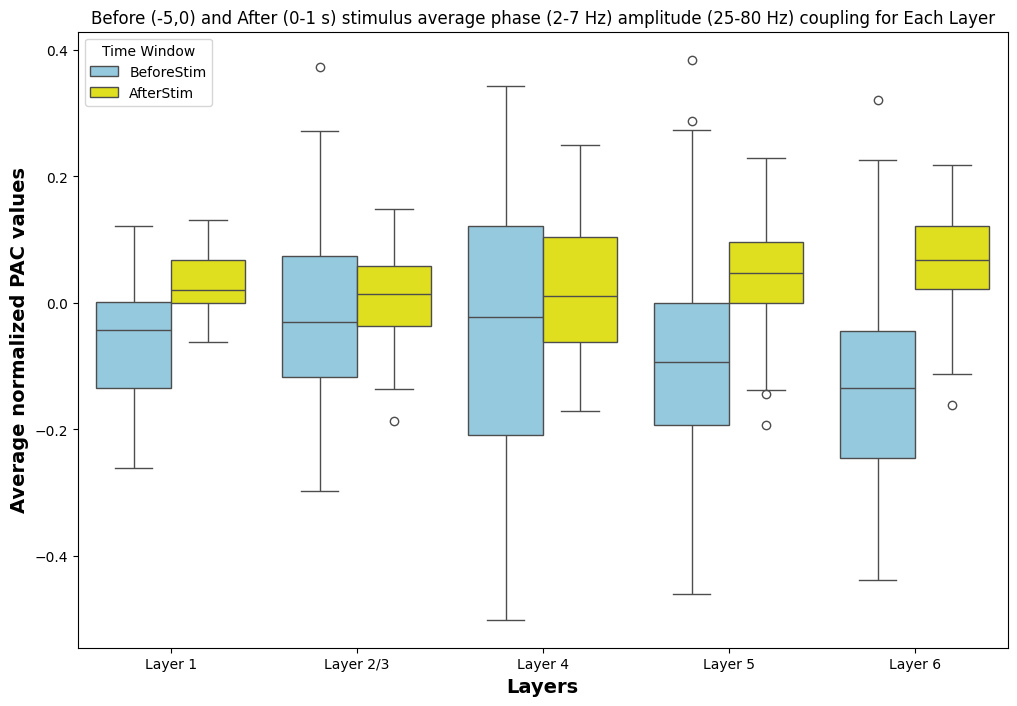

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
layer_averaged_data = pd.read_csv('layer_averaged_data.csv')

# Melt the data to make it suitable for seaborn boxplot
melted_data = layer_averaged_data.melt(id_vars=['Layer'], value_vars=['BeforeStim', 'AfterStim'], 
                                       var_name='Condition', value_name='Value')

# Set up the plotting environment
plt.figure(figsize=(12, 8))

# Define custom colors for the conditions
custom_palette = {'BeforeStim': 'skyblue', 'AfterStim': 'yellow'}

# Plot boxplots for each layer, ordered by layer number
sns.boxplot(x='Layer', y='Value', hue='Condition', data=melted_data, 
            order=sorted(melted_data['Layer'].unique()), palette=custom_palette)

# Add titles and labels
plt.title('Before (-5,0) and After (0-1 s) stimulus average phase (2-7 Hz) amplitude (25-80 Hz) coupling for Each Layer')
plt.xlabel('Layers', fontsize=14, fontweight='bold')
plt.ylabel('Average normalized PAC values', fontsize=14, fontweight='bold')
plt.legend(title='Time Window')

# Set custom x-tick labels
plt.xticks(ticks=range(len(melted_data['Layer'].unique())), 
           labels=['Layer 1', 'Layer 2/3', 'Layer 4', 'Layer 5', 'Layer 6'])

# Show the plot
plt.show()

# test normality 

In [32]:
# Import necessary libraries
from scipy.stats import shapiro

# Perform Shapiro-Wilk test for normality on BeforeStim and AfterStim
before_normality = shapiro(layer_averaged_data['BeforeStim'])
after_normality = shapiro(layer_averaged_data['AfterStim'])

print(before_normality, after_normality)

if before_normality[1] > 0.05:
    print('BeforeStim is normally distributed')
else:
    print('BeforeStim is not normally distributed')
if after_normality[1] > 0.05:
    print('AfterStim is normally distributed')
else:
    print('AfterStim is not normally distributed')

ShapiroResult(statistic=0.9825375451325683, pvalue=0.12924384526574367) ShapiroResult(statistic=0.9825375451325687, pvalue=0.12924384526575405)
BeforeStim is normally distributed
AfterStim is normally distributed


In [33]:
# Group the data by layer and perform the Shapiro-Wilk test for normality on BeforeStim and AfterStim for each layer
layer_groups = layer_averaged_data.groupby('Layer')

normality_results = {
    'Layer': [],
    'BeforeStim_pvalue': [],
    'AfterStim_pvalue': []
}

for layer, group in layer_groups:
    before_normality = shapiro(group['BeforeStim']).pvalue
    after_normality = shapiro(group['AfterStim']).pvalue
    
    normality_results['Layer'].append(layer)
    normality_results['BeforeStim_pvalue'].append(before_normality)
    normality_results['AfterStim_pvalue'].append(after_normality)

# Convert the results to a DataFrame
normality_results_df = pd.DataFrame(normality_results)

display(normality_results_df)


,Layer,BeforeStim_pvalue,AfterStim_pvalue
0,VISp1,0.795960,0.795960
1,VISp2,0.697352,0.697352
2,VISp4,0.917277,0.917277
3,VISp5,0.562419,0.562419
4,VISp6,0.119813,0.119813


# applying RM ANOVA

In [9]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM

# Reshape the data for repeated measures ANOVA
data_long = pd.melt(layer_averaged_data, id_vars=['PID', 'Layer'], value_vars=['BeforeStim', 'AfterStim'], 
                    var_name='Condition', value_name='Value')

# Perform Repeated Measures ANOVA
rm_anova = AnovaRM(data_long, depvar='Value', subject='PID', within=['Condition'], aggregate_func='mean')
rm_anova_results = rm_anova.fit()

rm_anova_results.summary()


,F Value,Num DF,Den DF,Pr > F
Condition,5.5030,1.0000,39.0000,0.0242


In [10]:
# Perform Repeated Measures ANOVA for each layer
rm_anova_per_layer_results = {}

for layer, group in data_long.groupby('Layer'):
    rm_anova = AnovaRM(group, depvar='Value', subject='PID', within=['Condition'], aggregate_func='mean')
    result = rm_anova.fit()
    rm_anova_per_layer_results[layer] = result.summary()

# rm_anova_per_layer_results


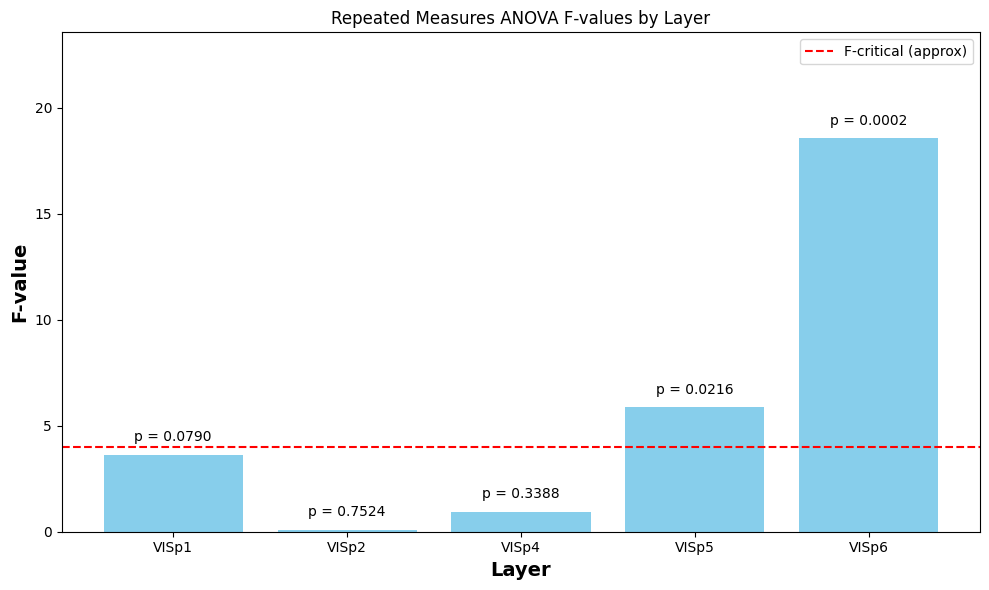

In [11]:

# Extract the F-values and p-values for each layer
layers = list(rm_anova_per_layer_results.keys())
f_values = [rm_anova_per_layer_results[layer].tables[0].iloc[0]['F Value'] for layer in layers]
p_values = [rm_anova_per_layer_results[layer].tables[0].iloc[0]['Pr > F'] for layer in layers]

# Create a bar plot for F-values and overlay the p-values as text
plt.figure(figsize=(10, 6))
bars = plt.bar(layers, f_values, color='skyblue')
plt.axhline(y=4.00, color='r', linestyle='--', label='F-critical (approx)')
plt.xlabel('Layer', fontsize=14, fontweight='bold')
plt.ylabel('F-value', fontsize=14, fontweight='bold')
plt.title('Repeated Measures ANOVA F-values by Layer')
plt.ylim(0, max(f_values) + 5)

# Annotate p-values on the bars
for bar, p_value in zip(bars, p_values):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'p = {p_value:.4f}', ha='center', va='bottom')

plt.legend()
plt.tight_layout()
plt.show()


# LMM

In [39]:
import statsmodels.formula.api as smf

# Reshape the data for linear mixed-effects model
data_long = pd.melt(data, id_vars=['PID', 'Layer'], value_vars=['BeforeStim', 'AfterStim'], 
                    var_name='Condition', value_name='Value')

# Fit the Linear Mixed-Effects Model
lme_model = smf.mixedlm("Value ~ Condition", data_long, groups=data_long["PID"], 
                        re_formula="~Condition").fit()

# Display the summary of the model
print(lme_model.summary())


/home/mohammad.keshtkar/miniconda3/envs/crnlenv/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/mohammad.keshtkar/miniconda3/envs/crnlenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/mohammad.keshtkar/miniconda3/envs/crnlenv/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/mohammad.keshtkar/miniconda3/envs/crnlenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(


                    Mixed Linear Model Regression Results
Model:                     MixedLM        Dependent Variable:        Value    
No. Observations:          4318           Method:                    REML     
No. Groups:                40             Scale:                     0.0128   
Min. group size:           4              Log-Likelihood:            3184.7815
Max. group size:           236            Converged:                 No       
Mean group size:           108.0                                              
------------------------------------------------------------------------------
                                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------
Intercept                            0.030    0.013  2.332 0.020  0.005  0.055
Condition[T.BeforeStim]             -0.090    0.038 -2.352 0.019 -0.166 -0.015
Group Var                            0.006    0.010                      

/home/mohammad.keshtkar/miniconda3/envs/crnlenv/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/mohammad.keshtkar/miniconda3/envs/crnlenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/home/mohammad.keshtkar/miniconda3/envs/crnlenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 42.018265
  warnings.warn(msg, ConvergenceWarning)
/home/mohammad.keshtkar/miniconda3/envs/crnlenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/

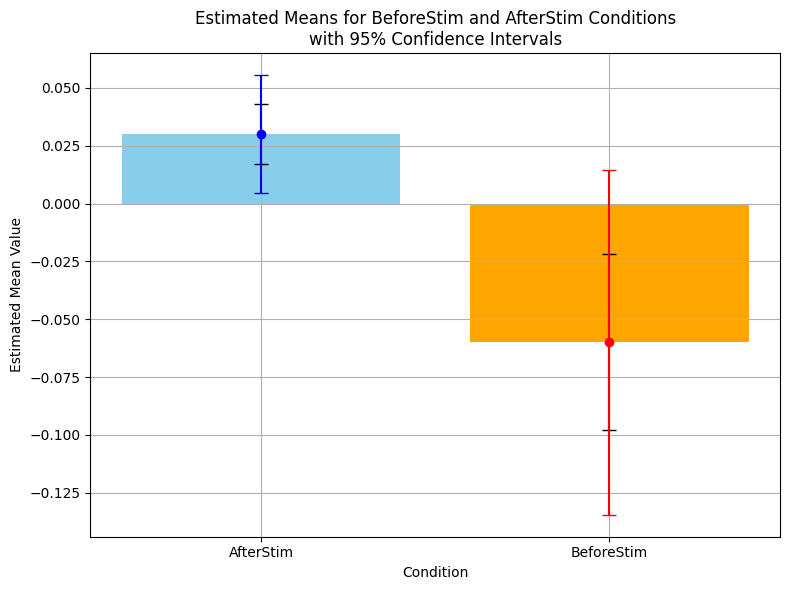

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Extracting the fixed effect estimates for the intercept and condition
intercept = 0.030
condition_effect = -0.090
error_intercept = 0.013
error_condition = 0.038

# Calculate the means for BeforeStim and AfterStim
mean_afterstim = intercept
mean_beforestim = intercept + condition_effect

# Confidence intervals (95% CI)
ci_afterstim = [mean_afterstim - 1.96*error_intercept, mean_afterstim + 1.96*error_intercept]
ci_beforestim = [mean_beforestim - 1.96*error_condition, mean_beforestim + 1.96*error_condition]

# Create a plot
plt.figure(figsize=(8, 6))

# Plot the means
plt.bar(['AfterStim', 'BeforeStim'], [mean_afterstim, mean_beforestim], color=['skyblue', 'orange'], yerr=[error_intercept, error_condition], capsize=5)

# Plot confidence intervals as lines
plt.errorbar('AfterStim', mean_afterstim, yerr=[[mean_afterstim-ci_afterstim[0]], [ci_afterstim[1]-mean_afterstim]], fmt='o', color='blue', capsize=5)
plt.errorbar('BeforeStim', mean_beforestim, yerr=[[mean_beforestim-ci_beforestim[0]], [ci_beforestim[1]-mean_beforestim]], fmt='o', color='red', capsize=5)

# Add labels and title
plt.xlabel('Condition')
plt.ylabel('Estimated Mean Value')
plt.title('Estimated Means for BeforeStim and AfterStim Conditions\nwith 95% Confidence Intervals')
plt.grid(True)

plt.tight_layout()
plt.show()
